In [1]:
# compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os

from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, roc_curve, confusion_matrix
import seaborn as sns

# stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# ignorer les warnings inutiles (voir SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os
import tarfile
from six.moves import urllib
import pandas as pd

EMPLOYEES_PATH = os.path.join("datasets", "employees")
TILME_PATH = os.path.join("datasets", "time")

def load_general_data(employees_path=EMPLOYEES_PATH):
    general_csv_path = os.path.join(employees_path, "general_data.csv")
    return pd.read_csv(general_csv_path)

def load_employees_data(employees_path=EMPLOYEES_PATH):
    employee_csv_path = os.path.join(employees_path, "employee_survey_data.csv")
    return pd.read_csv(employee_csv_path)

def load_manager_data(employees_path=EMPLOYEES_PATH):
    manager_csv_path = os.path.join(employees_path, "manager_survey_data.csv")
    return pd.read_csv(manager_csv_path)

def load_time_in_data(time_path=TILME_PATH):
    time_in_csv_path = os.path.join(time_path, "in_time.csv")
    return pd.read_csv(time_in_csv_path)

def load_time_out_data(time_path=TILME_PATH):
    time_out_csv_path = os.path.join(time_path, "out_time.csv")
    return pd.read_csv(time_out_csv_path)

# Loading all the data
general_df = load_general_data()
employees_df = load_employees_data()
manager_df = load_manager_data()
time_in_df = load_time_in_data()
time_out_df = load_time_out_data()

# Add EmployeeID column name
time_in_df.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
time_out_df.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
# Transform True/False string to 1:0
general_df['Attrition'] = general_df['Attrition'].map({'Yes': 1, 'No': 0})

# Merging surveys and general dataframes
merged_df = pd.merge(general_df, employees_df, on='EmployeeID')
merged_df = pd.merge(merged_df, manager_df, on='EmployeeID')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   int64  
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [2]:
# Convert string columns to datetime, handling None as NaT automatically
for col in time_in_df.columns[1:]:  # Skip 'EmployeeID' column
    time_in_df[col] = pd.to_datetime(time_in_df[col], errors='coerce')
    time_out_df[col] = pd.to_datetime(time_out_df[col], errors='coerce')

# Initialize a DataFrame to store the difference between in and out time
time_diff_df = time_in_df.copy()
for col in time_in_df.columns[1:]:  # Again, skip 'EmployeeID'
    time_diff_df[col] = time_out_df[col] - time_in_df[col]
    # Replace NaT with timedelta of zero
    time_diff_df[col] = time_diff_df[col].fillna(pd.Timedelta(seconds=0))

# Calculate the sum of work durations for each employee
total_duration = time_diff_df.drop(columns='EmployeeID').sum(axis=1)

# Calculate the number of datetime columns without the EmployeeID column
num_datetime_columns = len(time_diff_df.columns) - 1

# Calculate the average presence time per employee
average_presence_time = total_duration / num_datetime_columns

# Attach the results to the original EmployeeID
average_presence_df = pd.DataFrame({
    'EmployeeID': time_diff_df['EmployeeID'],
    'AveragePresence': average_presence_time
})

average_presence_df['AveragePresence'] = average_presence_df['AveragePresence'] / np.timedelta64(1, 'h')

In [3]:
merged_df = merged_df.merge(average_presence_df, left_on='EmployeeID', right_on='EmployeeID')

merged_df["GlobalSatisfaction"] = (merged_df["EnvironmentSatisfaction"] + merged_df["JobSatisfaction"] + merged_df["WorkLifeBalance"]) / 3
merged_df["GlobalPerformance"] = (merged_df["JobInvolvement"] + merged_df["PerformanceRating"]) / 2

data = merged_df.copy()

unethical_cols = ['Age', 'Gender', 'MaritalStatus', 'EmployeeID']
data = data.drop(unethical_cols, axis=1)

data.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,JobLevel,JobRole,MonthlyIncome,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AveragePresence,GlobalSatisfaction,GlobalPerformance
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,...,0,0,3.0,4.0,2.0,3,3,6.554356,3.000000,3.0
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,1,1,Research Scientist,41890,...,1,4,3.0,2.0,4.0,2,4,6.979604,3.000000,3.0
2,0,Travel_Frequently,Research & Development,17,4,Other,1,4,Sales Executive,193280,...,0,3,2.0,2.0,1.0,3,3,6.502698,1.666667,3.0
3,0,Non-Travel,Research & Development,2,5,Life Sciences,1,3,Human Resources,83210,...,7,5,4.0,4.0,3.0,2,3,6.477067,3.666667,2.5
4,0,Travel_Rarely,Research & Development,10,1,Medical,1,1,Sales Executive,23420,...,0,4,4.0,1.0,3.0,3,3,7.515375,2.666667,3.0


In [4]:
X = data.drop("Attrition", axis=1)  # Features
y = data["Attrition"]  # Labels

from sklearn.model_selection import StratifiedShuffleSplit 

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train, test in splitter.split(X, y):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Columns to exclude from imputation
numerical_columns_to_exclude = ['AveragePresence']

general_numerical = X.select_dtypes(include=[np.number])
general_numerical = general_numerical.drop(numerical_columns_to_exclude, axis=1)
numerical_attribs = list(general_numerical)

general_gategoric = X.select_dtypes(include=[object])
categoric_attribs = list(general_gategoric)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
        ('ordinal', OrdinalEncoder()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_attribs),
        ("cat", cat_pipeline, categoric_attribs)
    ],
    remainder='passthrough')

# Fit and transform the training data
X_train_transformed = full_pipeline.fit_transform(X_train)
# Transform the test data
X_test_transformed = full_pipeline.transform(X_test)
# Transform the original data - used to check accuracy
X_full_transformed = full_pipeline.transform(X)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

# Predictions
y_pred = clf.predict(X_test_transformed)

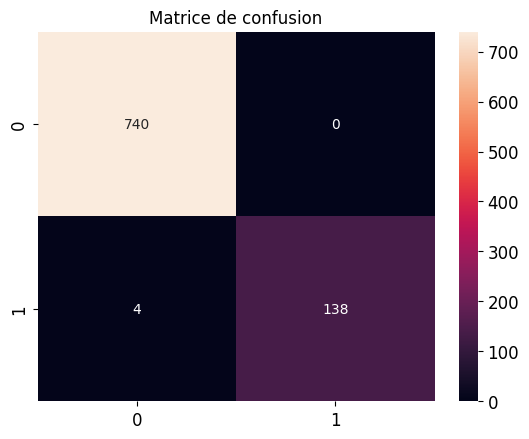

In [6]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.show()

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       740
           1       1.00      0.97      0.99       142

    accuracy                           1.00       882
   macro avg       1.00      0.99      0.99       882
weighted avg       1.00      1.00      1.00       882



In [8]:
y_proba = clf.predict_proba(X_test_transformed)[:, 1]  # Get probabilities of the positive class

auc_score = roc_auc_score(y_test, y_proba)
auc_score

0.9963408831366578

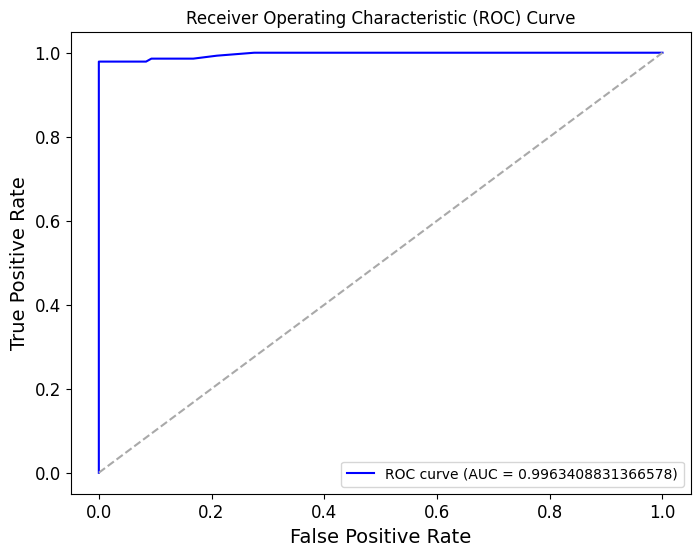

In [9]:
y_pred_prob = clf.predict_proba(X_test_transformed)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score})')
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

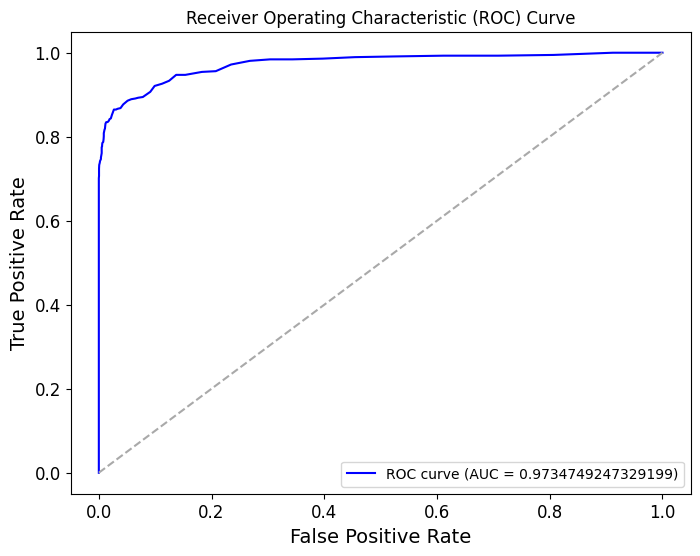

In [10]:
from sklearn.model_selection import cross_val_predict

y_probas_forest = cross_val_predict(clf, X_train_transformed, y_train, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores_forest)

auc_score = roc_auc_score(y_train, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score})')
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
clf_test = RandomForestClassifier()

clf_test.fit(X_train_transformed, y_train)

# Predict on training set
train_predictions = clf_test.predict(X_train_transformed)
train_accuracy = accuracy_score(y_train, train_predictions)

# Predict on test set
test_predictions = clf_test.predict(X_test_transformed)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.9943310657596371


In [12]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(clf_test, X_full_transformed, y, cv=5, scoring='accuracy')

print(f"Cross-validated scores: {scores}")
print(f"Mean CV Accuracy: {scores.mean()}")

Cross-validated scores: [0.99546485 0.99659864 0.99773243 0.99659864 0.99659864]
Mean CV Accuracy: 0.9965986394557824


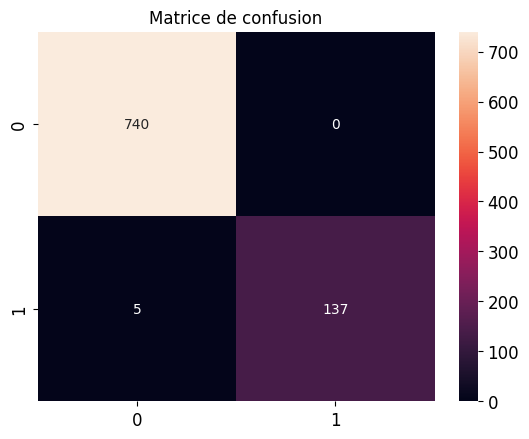

In [13]:
conf_mat = confusion_matrix(y_test, test_predictions)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.show()

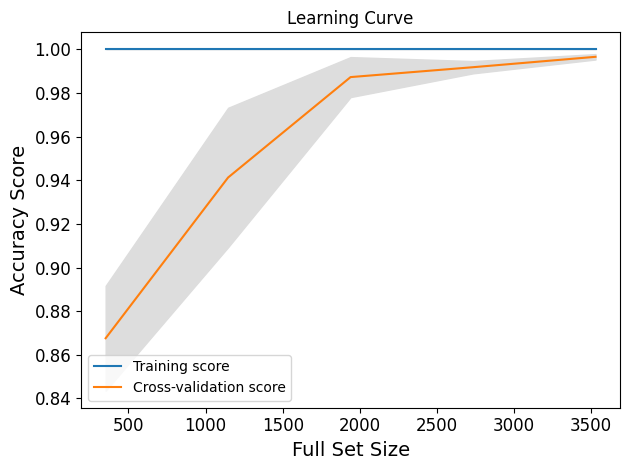

In [14]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(clf, X_full_transformed, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Full Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [15]:
# Get feature importance
importances = clf.feature_importances_

# To map these importances to the correct feature names:
feature_names = X_train.columns
feature_importances = sorted(zip(importances, feature_names), reverse=True)

print("Feature importances:")
for importance, name in feature_importances:
    print(f"{name}: {importance}")

Feature importances:
GlobalPerformance: 0.11218471656793899
NumCompaniesWorked: 0.09339835179925099
EducationField: 0.08096097136174894
PercentSalaryHike: 0.06078099677978655
BusinessTravel: 0.05770675124945493
JobLevel: 0.05035439882698561
EnvironmentSatisfaction: 0.050240295246869744
StockOptionLevel: 0.04608982523819467
EmployeeCount: 0.044222453036424705
AveragePresence: 0.04355651171043052
StandardHours: 0.03374997856609836
Over18: 0.03357492450068228
PerformanceRating: 0.0321796624518378
TotalWorkingYears: 0.031029882570307015
YearsAtCompany: 0.03051849516056177
TrainingTimesLastYear: 0.02796031152352483
Education: 0.027057410253874013
Department: 0.02647731685468818
MonthlyIncome: 0.02505987854046684
JobSatisfaction: 0.023556863037624564
WorkLifeBalance: 0.021584106930143124
YearsSinceLastPromotion: 0.020153005304834982
JobInvolvement: 0.02007446722802494
YearsWithCurrManager: 0.007528425260245583
JobRole: 0.0
GlobalSatisfaction: 0.0
DistanceFromHome: 0.0


In [16]:
from sklearn.inspection import permutation_importance

# Assuming clf is your trained model and X_test, y_test are your test datasets
result = permutation_importance(clf, X_test_transformed, y_test, n_repeats=10, random_state=42)

sorted_importances = sorted(zip(result.importances_mean, X_test.columns), reverse=True)
print("Permutation Feature Importances:")
for importance, name in sorted_importances:
    print(f"{name}: {importance}")

Permutation Feature Importances:
GlobalPerformance: 0.06893424036281183
NumCompaniesWorked: 0.04444444444444449
EnvironmentSatisfaction: 0.024036281179138343
PercentSalaryHike: 0.02097505668934242
StockOptionLevel: 0.018820861678004543
EmployeeCount: 0.01734693877551021
EducationField: 0.01723356009070297
StandardHours: 0.015306122448979609
TotalWorkingYears: 0.015079365079365114
AveragePresence: 0.010090702947845864
YearsAtCompany: 0.009863945578231337
JobLevel: 0.009863945578231337
Over18: 0.007029478458049942
JobInvolvement: 0.0066893424036281735
BusinessTravel: 0.006689342403628151
YearsSinceLastPromotion: 0.0063492063492063934
WorkLifeBalance: 0.006122448979591888
MonthlyIncome: 0.005668934240362855
TrainingTimesLastYear: 0.005555555555555591
Department: 0.0048752834467120755
PerformanceRating: 0.004421768707483032
JobSatisfaction: 0.004081632653061262
Education: 0.0011337868480725932
YearsWithCurrManager: 0.00022675736961452753
JobRole: 0.0
GlobalSatisfaction: 0.0
DistanceFromHom

In [17]:
clf.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

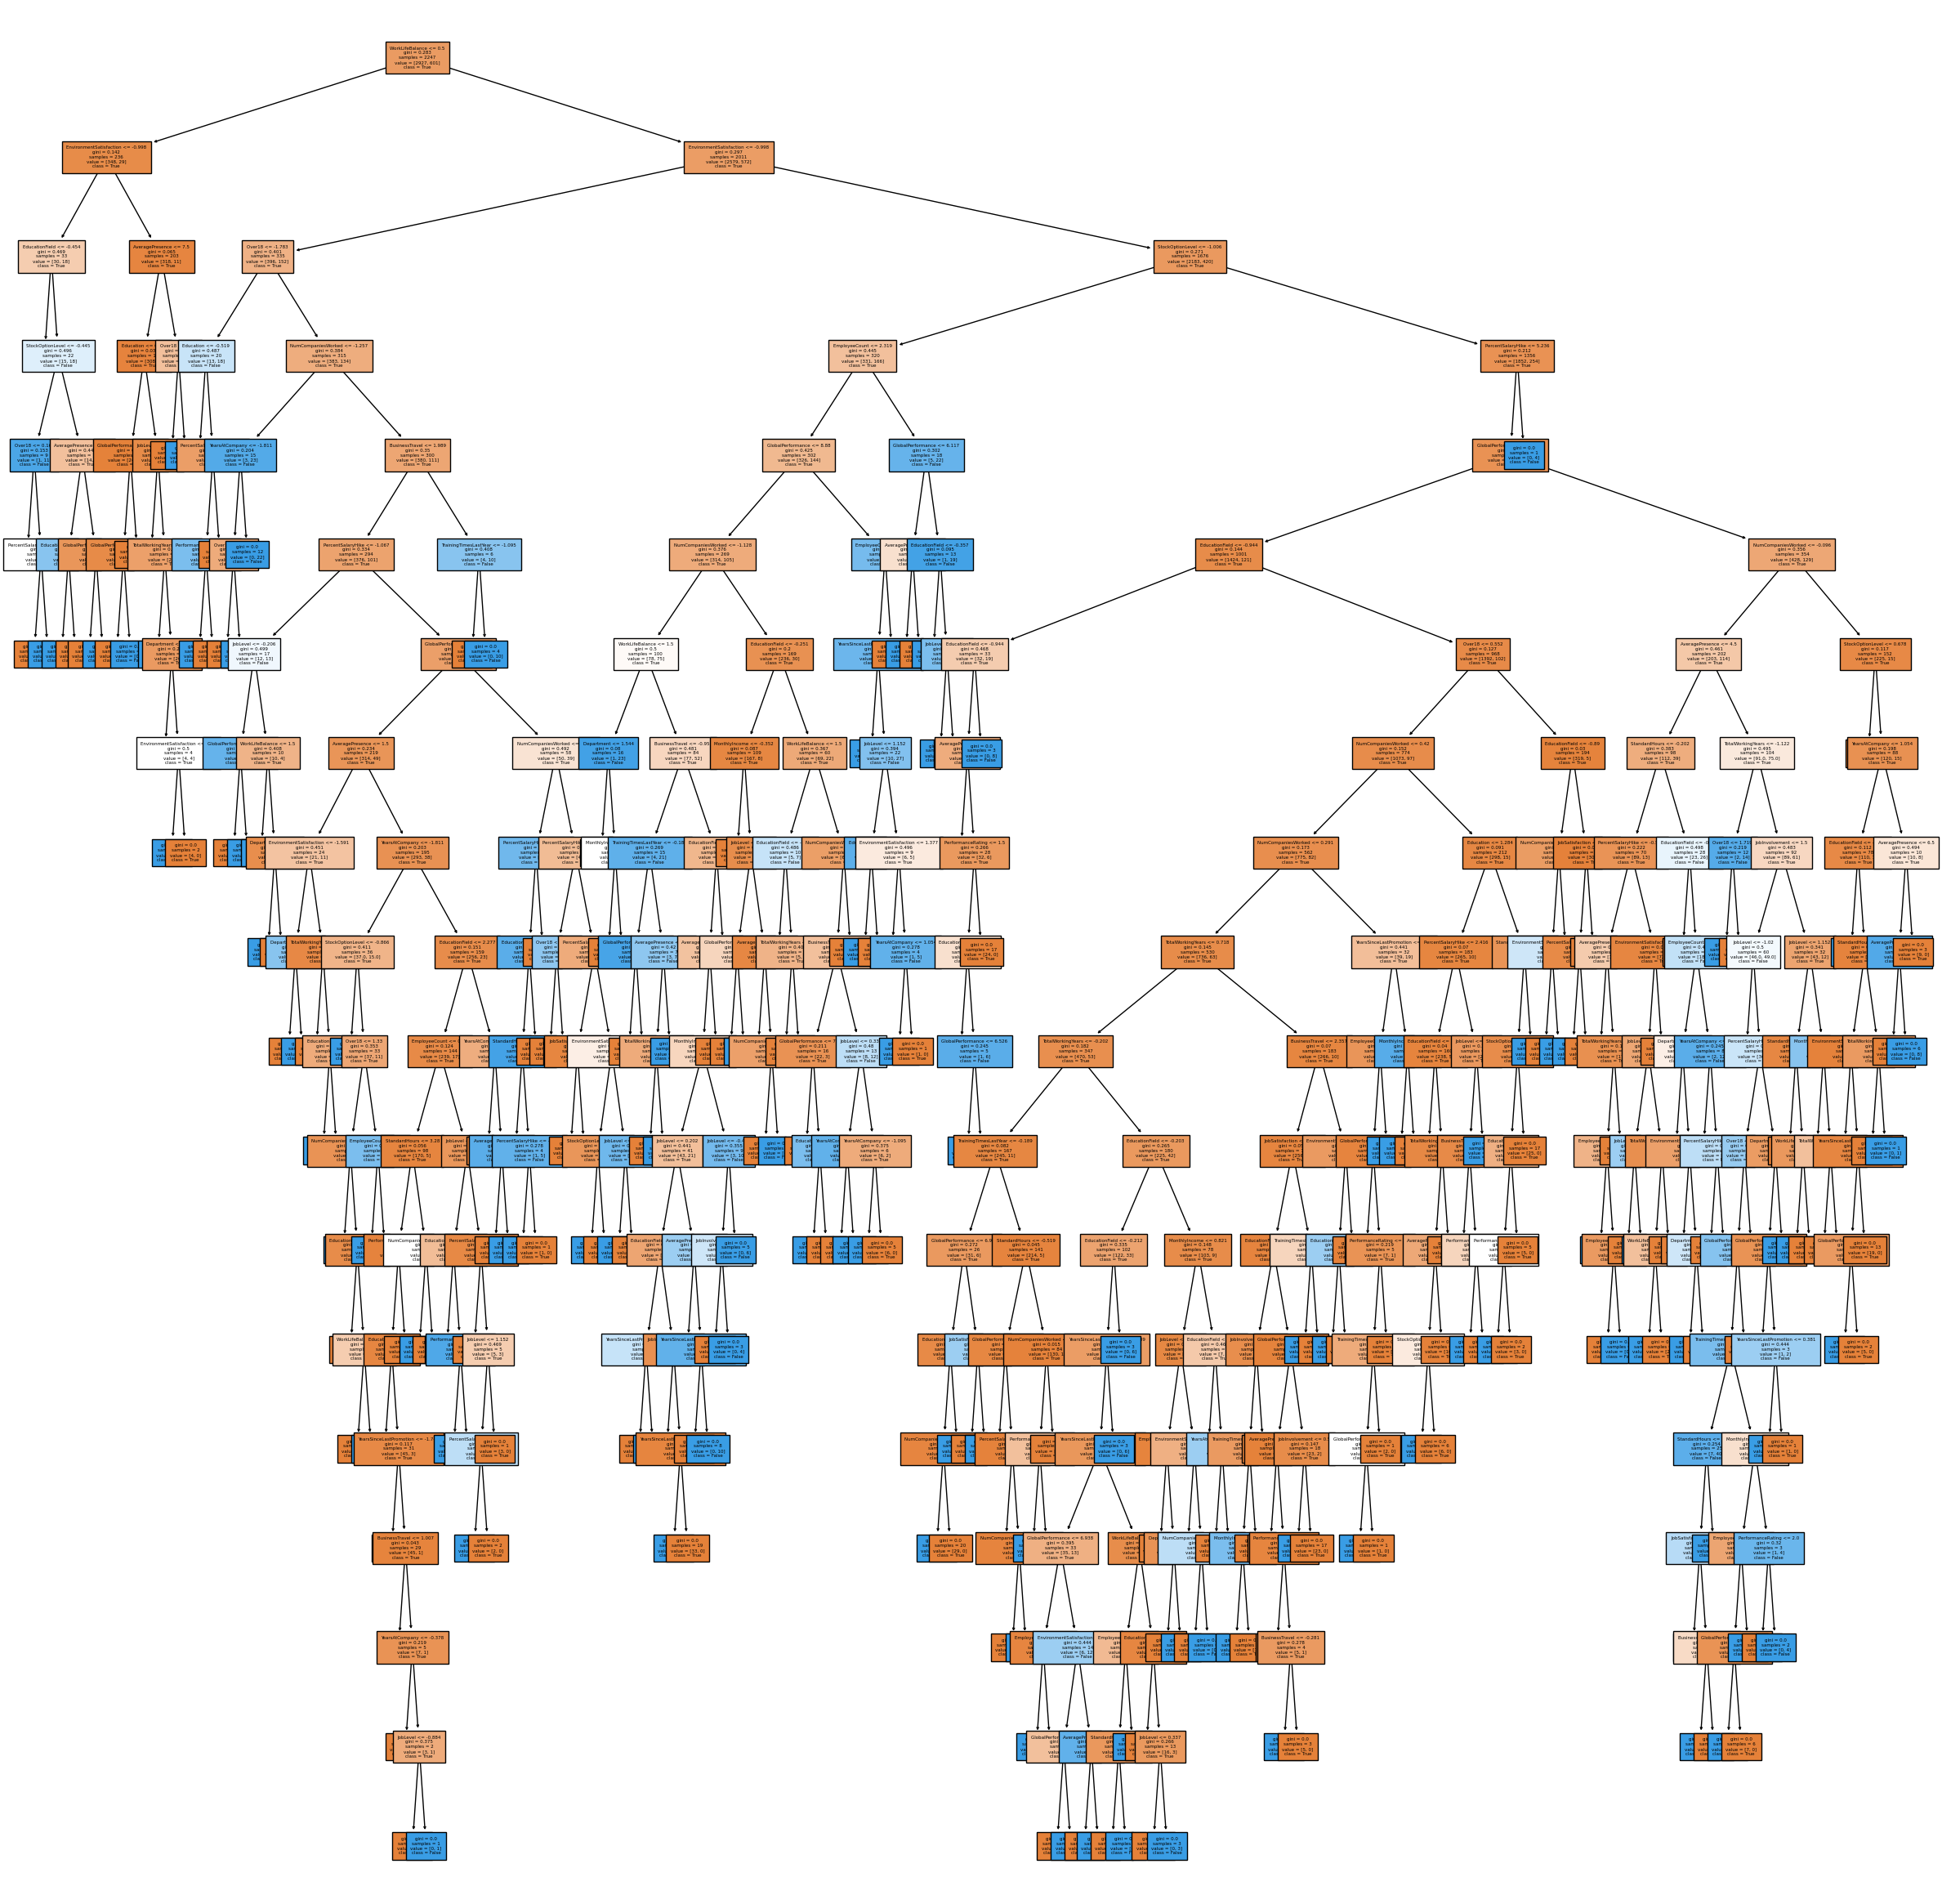

In [20]:
fn = X_train.columns
cn = ["True", "False"]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,30))

from sklearn.tree import plot_tree

plot_tree(clf.estimators_[21],
           feature_names = fn, 
           class_names=cn,
           filled = True,fontsize=4);